In [2]:
import sys; sys.path.insert(0, "..") 
from src.dataset.utils import get_balanced_initial_pool, train_test_val_split

from src.features.convert_images_to_npy import process_cncb_data; sys.path.insert(0, "..") 

root_dir = "../data/"
files, classes = process_cncb_data(root_dir=root_dir)

X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(
    files, classes, train_size=0.7, test_size=0.2
)
initial_pool = get_balanced_initial_pool(
    y_train, initial_pool=9
)

In [3]:
data = {}
data["X_train"] = X_train
data["y_train"] = y_train
data["X_test"] = X_test
data["y_test"] = y_test
data["X_val"] = X_val
data["y_val"] = y_val
data["inital_pool"] = initial_pool

In [ ]:
import pickle 
with open("datasets.pickle", "wb") as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
import sys; sys.path.insert(0, "..") 
import os
import matplotlib.pyplot as plt

In [4]:
from sklearn.datasets import make_blobs, make_classification

X, labels = make_blobs(n_samples=10000, n_features=2, centers=2)
x = [X[_][0] for _ in range(10000)]
y = [X[_][1] for _ in range(10000)]
# z = [X[_][2] for _ in range(10000)]

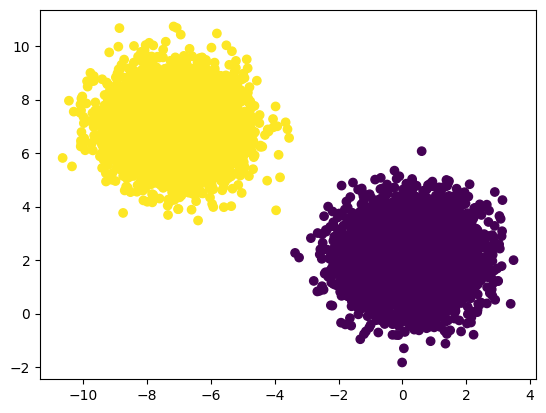

In [5]:
plt.scatter(x=x, y=y, c=labels)

In [7]:
# Let's start with a bunch of imports.

import random
from copy import deepcopy
from dataclasses import dataclass

import numpy as np
import torch
import torch.backends
import torch.utils.data as torchdata
from torch import optim
from torch.hub import load_state_dict_from_url
from torch.nn import CrossEntropyLoss
from torchvision import datasets
from torchvision import models
from torchvision.transforms import transforms
from tqdm.autonotebook import tqdm

from baal.active import get_heuristic, ActiveLearningDataset
from baal.active.active_loop import ActiveLearningLoop
from baal.bayesian.dropout import patch_module
from baal.modelwrapper import ModelWrapper


In [9]:
import torch.nn as nn

import baal.bayesian.dropout

class ToyModel(nn.Module):
    def __init__(self) -> None:
        super(ToyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            baal.bayesian.dropout.Dropout(p=0.5),
            nn.Linear(16, 32),
            nn.ReLU(),
            baal.bayesian.dropout.Dropout(p=0.5),
            nn.Linear(32, 64),
            # nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(64, 16),
            nn.ReLU(),
            baal.bayesian.dropout.Dropout(p=0.5),
            nn.Linear(16, 8),
            nn.ReLU(),
            baal.bayesian.dropout.Dropout(p=0.5),
            nn.Linear(8, 2)
        )
        self.model = nn.Sequential(self.features, self.classifier)
    def forward(self, x):
        return self.model(x)



In [10]:
from torch.utils.data import TensorDataset

X_tensor = torch.tensor(X).type(torch.float32)
labels_tensor = torch.tensor(labels).type(torch.long)

train_ds = TensorDataset(X_tensor, labels_tensor)

active_set = ActiveLearningDataset(train_ds)
active_set.label_randomly(500)

# for epoch in range(200):  # loop over the dataset multiple times
#     preds = []
#     running_loss = 0.0
#     for x, y in zip(X, labels):
#         x = torch.tensor(x).type(torch.float32)
#         y = torch.tensor(y).type(torch.float32)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(x.unsqueeze(0))
#         loss = criterion(outputs.squeeze(), y)
#         loss.backward()
#         optimizer.step()
#         preds.append(outputs.detach().cpu().round())
#         # print statistics
#         # print(f'[{epoch + 1}, {epoch + 1:5d}] loss: {loss.item()}')
#     print((np.hstack(preds)==labels).mean())
# print('Finished Training')

In [15]:
from torchmetrics import Accuracy


use_cuda = torch.cuda.is_available()
torch.backends.cudnn.benchmark = True
random.seed(1337)
torch.manual_seed(1337)
if not use_cuda:
    print("warning, the experiments would take ages to run on cpu")


# Get our model.
from baal.active.heuristics import BALD
heuristic = BALD()

criterion = nn.CrossEntropyLoss()
model = ToyModel()

# change dropout layer to MCDropout
model = patch_module(model)

if use_cuda:
    model.cuda()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# Wraps the model into a usable API.
model = ModelWrapper(model, criterion)
# model.add_metric(name="accuracy", initializer=lambda: Accuracy().cuda())
# for ActiveLearningLoop we use a smaller batchsize
# since we will stack predictions to perform MCDropout.
active_loop = ActiveLearningLoop(active_set,
                                 model.predict_on_dataset,
                                 heuristic,
                                 100,
                                 batch_size=1,
                                 iterations=40,
                                 use_cuda=use_cuda,
                                 verbose=False)

# We will reset the weights at each active learning step so we make a copy.
init_weights = deepcopy(model.state_dict())
print(f"Num. labeled: {len(active_set)}/{len(train_ds)}")

c:\Users\Bastian\Desktop\Deep-Bayesian-Active-Learning-for-Covid-19\venv\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)


Num. labeled: 500/10000


In [16]:
# 2. Train the model for a few epoch on the training set.
model.train_on_dataset(active_set, optimizer, batch_size=16, epoch=5, use_cuda=True)
# model.test_on_dataset(test_dataset, batch_size=16, use_cuda=USE_CUDA)

print("Metrics:", {k:v.avg for k,v in model.metrics.items()})


[12672-MainThread] [baal.modelwrapper:train_on_dataset:83] 2023-05-21T11:03:37.053368Z [info     ] Starting training              dataset=500 epoch=5
[12672-MainThread] [baal.modelwrapper:train_on_dataset:94] 2023-05-21T11:03:54.276607Z [info     ] Training complete              train_loss=0.6187668442726135
Metrics: {'test_loss': nan, 'train_loss': 0.6187668442726135}


In [17]:


# 3. Select the K-top uncertain samples according to the heuristic.
pool = active_set.pool
if len(pool) == 0:
  raise ValueError("We're done!")

# We make 15 MCDropout iterations to approximate the uncertainty.
predictions = model.predict_on_dataset(pool, batch_size=16, iterations=15, use_cuda=use_cuda, verbose=False)
# We will label the 10 most uncertain samples.
top_uncertainty = heuristic(predictions)[:10]


[12672-MainThread] [baal.modelwrapper:predict_on_dataset_generator:232] 2023-05-21T11:04:11.343052Z [info     ] Start Predict                  dataset=9500


In [18]:
top_uncertainty

array([ 268, 6494, 7223, 4756,  877, 4452, 6824, 5318, 6425,    5],
      dtype=int64)

In [34]:
labelling_progress = active_set._labelled.copy().astype(np.uint16)
for epoch in tqdm(range(10)):
    # Load the initial weights.
    model.load_state_dict(init_weights)

    # Train the model on the currently labelled dataset.
    _ = model.train_on_dataset(active_set, optimizer=optimizer, batch_size=16,
                               use_cuda=use_cuda, epoch=10)

    metrics = model.metrics
    # print("train acc: {}".format(model.get_metrics()["train_accuracy"]))
    # We can now label the most uncertain samples according to our heuristic.
    should_continue = active_loop.step()
    # Keep track of progress
    labelling_progress += active_set._labelled.astype(np.uint16)
    if not should_continue:
        break

    train_loss = metrics['train_loss'].value
    logs = {
        "train_nll": train_loss,
        "epoch": epoch,
        "Next Training set size": len(active_set)
    }

  0%|          | 0/10 [00:00<?, ?it/s]

[11504-MainThread] [baal.modelwrapper:train_on_dataset:83] 2023-05-16T14:46:56.797005Z [info     ] Starting training              dataset=500 epoch=10
[11504-MainThread] [baal.modelwrapper:train_on_dataset:94] 2023-05-16T14:47:19.250512Z [info     ] Training complete              train_loss=1.04092276096344
[11504-MainThread] [baal.modelwrapper:predict_on_dataset_generator:232] 2023-05-16T14:47:19.255512Z [info     ] Start Predict                  dataset=9500


 10%|█         | 1/10 [00:32<04:49, 32.17s/it]

[11504-MainThread] [baal.modelwrapper:train_on_dataset:83] 2023-05-16T14:47:28.970968Z [info     ] Starting training              dataset=600 epoch=10
[11504-MainThread] [baal.modelwrapper:train_on_dataset:94] 2023-05-16T14:47:50.976839Z [info     ] Training complete              train_loss=1.0461915731430054
[11504-MainThread] [baal.modelwrapper:predict_on_dataset_generator:232] 2023-05-16T14:47:50.981839Z [info     ] Start Predict                  dataset=9400


 20%|██        | 2/10 [01:03<04:15, 31.94s/it]

[11504-MainThread] [baal.modelwrapper:train_on_dataset:83] 2023-05-16T14:48:00.749216Z [info     ] Starting training              dataset=700 epoch=10
[11504-MainThread] [baal.modelwrapper:train_on_dataset:94] 2023-05-16T14:48:23.160394Z [info     ] Training complete              train_loss=1.0184764862060547
[11504-MainThread] [baal.modelwrapper:predict_on_dataset_generator:232] 2023-05-16T14:48:23.165394Z [info     ] Start Predict                  dataset=9300


 30%|███       | 3/10 [01:36<03:44, 32.00s/it]

[11504-MainThread] [baal.modelwrapper:train_on_dataset:83] 2023-05-16T14:48:32.827936Z [info     ] Starting training              dataset=800 epoch=10
[11504-MainThread] [baal.modelwrapper:train_on_dataset:94] 2023-05-16T14:48:55.723406Z [info     ] Training complete              train_loss=1.026134967803955
[11504-MainThread] [baal.modelwrapper:predict_on_dataset_generator:232] 2023-05-16T14:48:55.728406Z [info     ] Start Predict                  dataset=9200


 40%|████      | 4/10 [02:08<03:13, 32.26s/it]

[11504-MainThread] [baal.modelwrapper:train_on_dataset:83] 2023-05-16T14:49:05.474234Z [info     ] Starting training              dataset=900 epoch=10
[11504-MainThread] [baal.modelwrapper:train_on_dataset:94] 2023-05-16T14:49:28.142405Z [info     ] Training complete              train_loss=0.9938358664512634
[11504-MainThread] [baal.modelwrapper:predict_on_dataset_generator:232] 2023-05-16T14:49:28.147407Z [info     ] Start Predict                  dataset=9100


 50%|█████     | 5/10 [02:40<02:40, 32.19s/it]

[11504-MainThread] [baal.modelwrapper:train_on_dataset:83] 2023-05-16T14:49:37.554191Z [info     ] Starting training              dataset=1000 epoch=10
[11504-MainThread] [baal.modelwrapper:train_on_dataset:94] 2023-05-16T14:50:00.503218Z [info     ] Training complete              train_loss=0.9773314595222473
[11504-MainThread] [baal.modelwrapper:predict_on_dataset_generator:232] 2023-05-16T14:50:00.509218Z [info     ] Start Predict                  dataset=9000


 60%|██████    | 6/10 [03:13<02:08, 32.24s/it]

[11504-MainThread] [baal.modelwrapper:train_on_dataset:83] 2023-05-16T14:50:09.881688Z [info     ] Starting training              dataset=1100 epoch=10
[11504-MainThread] [baal.modelwrapper:train_on_dataset:94] 2023-05-16T14:50:33.055575Z [info     ] Training complete              train_loss=0.9752617478370667
[11504-MainThread] [baal.modelwrapper:predict_on_dataset_generator:232] 2023-05-16T14:50:33.060576Z [info     ] Start Predict                  dataset=8900


 70%|███████   | 7/10 [03:45<01:36, 32.28s/it]

[11504-MainThread] [baal.modelwrapper:train_on_dataset:83] 2023-05-16T14:50:42.256670Z [info     ] Starting training              dataset=1200 epoch=10
[11504-MainThread] [baal.modelwrapper:train_on_dataset:94] 2023-05-16T14:51:05.655322Z [info     ] Training complete              train_loss=0.9623473286628723
[11504-MainThread] [baal.modelwrapper:predict_on_dataset_generator:232] 2023-05-16T14:51:05.661346Z [info     ] Start Predict                  dataset=8800


 80%|████████  | 8/10 [04:18<01:05, 32.57s/it]

[11504-MainThread] [baal.modelwrapper:train_on_dataset:83] 2023-05-16T14:51:15.454988Z [info     ] Starting training              dataset=1300 epoch=10
[11504-MainThread] [baal.modelwrapper:train_on_dataset:94] 2023-05-16T14:51:39.519522Z [info     ] Training complete              train_loss=0.9491784572601318
[11504-MainThread] [baal.modelwrapper:predict_on_dataset_generator:232] 2023-05-16T14:51:39.526527Z [info     ] Start Predict                  dataset=8700


 90%|█████████ | 9/10 [04:52<00:32, 32.88s/it]

[11504-MainThread] [baal.modelwrapper:train_on_dataset:83] 2023-05-16T14:51:49.003267Z [info     ] Starting training              dataset=1400 epoch=10
[11504-MainThread] [baal.modelwrapper:train_on_dataset:94] 2023-05-16T14:52:12.850417Z [info     ] Training complete              train_loss=0.9295762777328491
[11504-MainThread] [baal.modelwrapper:predict_on_dataset_generator:232] 2023-05-16T14:52:12.856414Z [info     ] Start Predict                  dataset=8600


100%|██████████| 10/10 [05:25<00:00, 32.56s/it]


In [35]:
# modify our model to get features
from torch import nn
from torch.utils.data import DataLoader


# Make a feature extractor from our trained model.
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return torch.flatten(self.model.features(x), 1)


features = FeatureExtractor(model.model)
acc = []
for x, y in DataLoader(active_set._dataset, batch_size=10):
    acc.append((features(x.cuda()).detach().cpu().numpy(), y.detach().cpu().numpy()))

xs, ys = zip(*acc)

In [36]:
from sklearn.manifold import TSNE

# Compute t-SNE on the extracted features.
tsne = TSNE(n_jobs=4)
transformed = tsne.fit_transform(np.vstack(xs))

In [37]:
labels = np.concatenate(ys)
labels.shape

(10000,)

In [38]:
from baal.utils.plot_utils import make_animation_from_data

# Create frames to animate the process.
frames = make_animation_from_data(transformed, labels, labelling_progress, ["0", "1", "2"])


In [39]:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation


def plot_images(img_list):
    def init():
        img.set_data(img_list[0])
        return (img,)

    def animate(i):
        img.set_data(img_list[i])
        return (img,)

    fig = plt.Figure(figsize=(10, 10))
    ax = fig.gca()
    img = ax.imshow(img_list[0])
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(img_list), interval=60, blit=True)
    return anim


HTML(plot_images(frames).to_jshtml())

In [14]:
from baal.modelwrapper import ModelWrapper

wrapped_model = ModelWrapper(
    model,
    torch.nn.CrossEntropyLoss()
)
with torch.no_grad():
    predictions = wrapped_model.predict_on_batch(torch.tensor(X).type(torch.float32), iterations=10000)

TypeError: 'ModelWrapper' object is not callable

In [ ]:

predictions.shape

In [ ]:
predictions[0, :, :]